In [2]:
import requests
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import copy
import time
import random
import threading
import coinconfig

from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
from binance.helpers import round_step_size
from futures_sign import send_signed_request, send_public_request
from cred import KEY, SECRET

In [3]:
#0:BTCBUSD, 1:BTCUSDT, 2:DOGEUSDT, 3:DOGEBUSD, 4:ETHBUSD, 5:ETHUSDT, 6:EOSUSDT, 7:LTCUSDT, 8:BNBBUSD

In [4]:
client = Client(KEY, SECRET, testnet=False)
config=coinconfig.tradeconfig
coin=coinconfig.coinlist[4]

In [5]:
symbol=coin["symbol"]
asset=coin["asset"]
recvWindow=config["recvWindow"]
dualSidePosition=config["dualSidePosition"]
marginType=config["marginType"]

leverage=coin["leverage"]
roundity=coin["roundity"]
profit_percent=coin["profit_percent"]
diference=coin["diference"]
stop_percent=profit_percent+diference
balance_part=coin["balance_part"]
compensation=coin["compensation"]
ingebit=coin["ingebit"]


In [6]:
client.futures_change_leverage(symbol=symbol, leverage=leverage, recvWindow=recvWindow)

{'symbol': 'ETHBUSD', 'leverage': 50, 'maxNotionalValue': '50000'}

In [7]:
# Margin type
def margin_type_to_isolated():
    status = client.futures_account()
    positions=pd.DataFrame(status['positions'])
    body=positions[positions['symbol']==symbol]['isolated'].astype(bool).tolist()[0]

    if body==True:
        client.futures_change_margin_type(symbol=symbol, marginType=marginType, recvWindow=recvWindow)
        print(f'Changed to {marginType}')
    else:
        print(f'Already {marginType}')

In [8]:
margin_type_to_isolated()

Already CROSSED


In [9]:
# Hedge mode turn on

def hedge_mode_turn_on():
    status=client.futures_get_position_mode() 
    if status['dualSidePosition']==False:
        client.futures_change_position_mode(dualSidePosition=dualSidePosition, recvWindow=recvWindow)
        client.futures_get_position_mode()
        print('Dual turned on')
    else:
        print('Already Dual')
    return(status['dualSidePosition'])

In [10]:
hedge_mode_turn_on()

Already Dual


True

In [11]:
def get_assetbalance(symbol):
    status = client.futures_account()
    balance = pd.DataFrame(status['assets'])
    assetbalance = float(balance.loc[balance['asset'] == asset, 'availableBalance'])
    return(assetbalance)

In [12]:
# Find all opened positions

def get_opened_positions(symbol):
    status = client.futures_account()
    positions=pd.DataFrame(status['positions'])
    open_positions=positions[positions['symbol']==symbol]
    position_long=float(open_positions[open_positions['positionSide']=='LONG']['entryPrice'])
    if position_long>0:
        position=position_long
    else:
        position=float(open_positions[open_positions['positionSide']=='SHORT']['entryPrice'])
    return(position)

In [13]:
get_opened_positions(symbol)

1217.59

In [14]:
# Close all orders 

def check_and_close_orders(symbol):
    global isStop 
    a=client.futures_get_open_orders(symbol=symbol)
    if len(a)>0:
        isStop = False
        client.futures_cancel_all_open_orders(symbol=symbol)

In [15]:
def get_symbol_price(symbol):
    prices = client.get_all_tickers()
    df=pd.DataFrame(prices)
    return float(df[ df['symbol']==symbol]['price'])

In [16]:
get_symbol_price(symbol)

1218.19

In [17]:
#получить tick size

def get_tick_size(symbol):
    data = client.futures_exchange_info()
    tick_size = 0.0
    the_symbol = symbol

    found = False
    info = data['symbols']
    for s in range(len(info)):
        if info[s]['symbol'] == the_symbol:
            filters = info[s]['filters']
            for f in range(len(filters)):
                if filters[f]['filterType'] == 'PRICE_FILTER':
                    tick_size = float(filters[f]['tickSize'])
                    found = True
                    break
            break
    return(tick_size)

In [18]:
#Trade config

# maxposition=0.016 #1 = 100% = 1 BTC,
asset_balance=get_assetbalance(symbol)
symbol_price=get_symbol_price(symbol)
maxposition=round(asset_balance*balance_part*leverage/symbol_price,3)
quantity=str(round(maxposition/2,roundity))
tick_size=get_tick_size(symbol)
symbolround=abs(str(tick_size).find('.') - len(str(tick_size))) - 1
quantity

'0.018'

In [19]:
#Stop loss LONG 
def open_sl_long(symbol,quant,tick_size,stop_percent):
    try:
        entry_price=get_opened_positions(symbol)
        stop_price_trigger=str(round(float(entry_price)*(1-stop_percent), symbolround))
        stop_price=str(round(float(stop_price_trigger)*0.9999, symbolround))
        tick=str(tick_size)
        params = {
            "batchOrders": [
                {
                    "symbol":symbol,
                    "side": "SELL",
                    "positionSide": "LONG",
                    "type": "STOP",
                    "quantity": quant,
                    "timeInForce":"GTE_GTC",
                    "tickSize": tick,
                    "stopPrice": stop_price_trigger,
                    "price": stop_price
                }
            ]
        }

        open_position_sl_long_response=send_signed_request('POST', '/fapi/v1/batchOrders', params)
        long_sl_opened=float(open_position_sl_long_response[0]['price'])
        print('LONG sl order opened price:'+str(long_sl_opened))
        return(long_sl_opened)
    
    except :
        print('\n\nSL long not open...')
        

In [20]:
#Take Profit LONG 

def open_tp_long(symbol,quant,tick_size,profit_percent):
    try:
        entry_price=get_opened_positions(symbol)
        take_price_trigger=str(round(float(entry_price)*(1+profit_percent), symbolround))
        take_price=str(round(float(take_price_trigger)*0.9999, symbolround))
        tick=str(tick_size)
        params = {
            "batchOrders": [
                {
                    "symbol":symbol,
                    "side": "SELL",
                    "positionSide": "LONG",
                    "type": "TAKE_PROFIT",
                    "quantity": quant,
                    "timeInForce":"GTE_GTC",
                    "tickSize": tick,
                    "stopPrice": take_price_trigger,
                    "price": take_price
                }
            ]
        }
        open_position_tp_long_response=send_signed_request('POST', '/fapi/v1/batchOrders', params)
        long_tp_opened=float(open_position_tp_long_response[0]['price'])
        print('LONG tp order opened price:'+str(long_tp_opened))
        return(long_tp_opened)
        
    except :
        print('\n\nTP long not open...')
    return(profit_percent,stop_percent)

In [21]:
#Открыть sl&tp LONG если есть позиция

def long_tp_sl_opening(symbol,quant,profit_percent,stop_percent):
    orders=client.futures_get_open_orders(symbol=symbol)
    orders_df=pd.DataFrame(orders)
    if orders_df.empty:
        x = threading.Thread(target=open_tp_long, args=(symbol,quant,tick_size,profit_percent))
        x.start()
        y = threading.Thread(target=open_sl_long, args=(symbol,quant,tick_size,stop_percent))
        y.start()
    else:
        print('LONG SL TP iteration continious..')
    return(profit_percent,stop_percent)

In [22]:
#Открыть позицию LONG 

def open_position_long(symbol,quantity,tick_size,profit_percent,stop_percent):
    sprice=get_symbol_price(symbol)
    close_price=str(round(sprice*(1+0.002),symbolround))
    tick=str(tick_size)
    params = {
        "batchOrders": [
            {
                "symbol":symbol,
                "side": "BUY",
                "positionSide": "LONG",
                "type": "LIMIT",
                "quantity": quantity,
                "timeInForce":"GTC",
                "tickSize": tick,
                "price": close_price        
            }
        ]
    }
    open_position_long_response=send_signed_request('POST', '/fapi/v1/batchOrders', params)
    long_opened=float(open_position_long_response[0]['price'])
    print('LONG order opened price:'+str(long_opened))
    if long_opened>0:
        long_tp_sl=long_tp_sl_opening(symbol,quantity,profit_percent,stop_percent)
    return(long_opened)

In [23]:
#Stop loss SHORT 

def open_sl_short(symbol,quant,tick_size,stop_percent):
    try:
        entry_price=get_opened_positions(symbol)
        stop_price_trigger=str(round(float(entry_price)*(1+stop_percent), symbolround))
        stop_price=str(round(float(stop_price_trigger)*1.0001, symbolround))
        tick=str(tick_size)
        params = {
            "batchOrders": [
                {
                    "symbol":symbol,
                    "side": "BUY",
                    "positionSide": "SHORT",
                    "type": "STOP",
                    "quantity": quant,
                    "timeInForce":"GTE_GTC",
                    "tickSize": tick,
                    "stopPrice": stop_price_trigger,
                    "price": stop_price
                }
            ]
        }
        
        open_position_sl_short_response=send_signed_request('POST', '/fapi/v1/batchOrders', params)
        short_sl_opened=float(open_position_sl_short_response[0]['price'])
        print('SHORT sl order opened price:'+str(short_sl_opened))
        return(short_sl_opened)
    
    except :
        print('\n\nSL short not open...')


In [24]:
#Take Profit SHORT

def open_tp_short(symbol,quant,tick_size,profit_percent):
    try:
        entry_price=get_opened_positions(symbol)
        take_price_trigger=str(round(float(entry_price)*(1-profit_percent), symbolround))
        take_price=str(round(float(take_price_trigger)*1.0001, symbolround))
        tick=str(tick_size)
        params = {
            "batchOrders": [
                {
                    "symbol":symbol,
                    "side": "BUY",
                    "positionSide": "SHORT",
                    "type": "TAKE_PROFIT",
                    "quantity": quant,
                    "timeInForce":"GTE_GTC",
                    "tickSize": tick,
                    "stopPrice": take_price_trigger,
                    "price": take_price
                }
            ]
        }

        open_position_tp_short_response=send_signed_request('POST', '/fapi/v1/batchOrders', params)
        short_tp_opened=float(open_position_tp_short_response[0]['price'])
        print('SHORT tp order opened price:'+str(short_tp_opened))
        return(short_tp_opened)
    
    except :
        print('\n\nTp short not open...')


In [25]:
#Открыть sl&tp SHORT если есть позиция
       
def short_tp_sl_opening(symbol,quant,profit_percent,stop_percent):
    orders=client.futures_get_open_orders(symbol=symbol)
    orders_df=pd.DataFrame(orders)
    if orders_df.empty:
        x = threading.Thread(target=open_tp_short, args=(symbol,quant,tick_size,profit_percent))
        x.start()
        y = threading.Thread(target=open_sl_short, args=(symbol,quant,tick_size,stop_percent))
        y.start()
    else:
        print('SHORT SL TP iteration continious..')

In [26]:
#Открыть позицию SHORT

def open_position_short(symbol,quantity,tick_size,profit_percent,stop_percent):
    sprice=get_symbol_price(symbol)
    close_price=str(round(sprice*(1-0.002),symbolround))
    tick=str(tick_size)
    params = {
        "batchOrders": [
            {
                "symbol":symbol,
                "side": "SELL",
                "positionSide": "SHORT",
                "type": "LIMIT",
                "quantity": quantity,
                "timeInForce":"GTC",
                "tickSize": tick,
                "price": close_price        
            }
        ]
    }
    open_position_short_response=send_signed_request('POST', '/fapi/v1/batchOrders', params)
    short_opened=float(open_position_short_response[0]['price'])
    print('SHORT order opened price:'+str(short_opened))
    if short_opened>0:
        short_tp_sl=short_tp_sl_opening(symbol,quantity,profit_percent,stop_percent)
    return(short_opened)

In [27]:
def get_profit(symbol):
    trades = client.futures_account_trades(symbol=symbol)
    dataset=pd.DataFrame(trades).iloc[-50:]
    bnbcom=dataset[dataset['commissionAsset']=='BNB']['commission'].astype(float).sum()
    busdcom=dataset[dataset['commissionAsset']==asset]['commission'].astype(float).sum()
    com=(bnbcom*270+busdcom)*-1
    real=dataset['realizedPnl'].astype(float).sum()
    profit=float(com+real)
    print(profit)

In [31]:
trades = client.futures_account_trades(symbol=symbol)
dataset=pd.DataFrame(trades).iloc[-39:]
data = dataset.loc[dataset['realizedPnl'] != '0']
data#['realizedPnl'].astype(float).sum()

,symbol,id,orderId,side,price,qty,realizedPnl,marginAsset,quoteQty,commission,commissionAsset,time,positionSide,buyer,maker
452,ETHBUSD,305613750,14629770867,SELL,1226.51,0.005,-0.00615000,BUSD,6.13255,0.00000606,BNB,1668896915089,LONG,False,False
453,ETHBUSD,305615410,14629775173,SELL,1229.57,0.020,0.03660000,BUSD,24.59140,0.00002431,BNB,1668897003551,LONG,False,False
454,ETHBUSD,305616952,14629770563,SELL,1231.31,0.015,0.05355000,BUSD,18.46965,0.00001825,BNB,1668897050949,LONG,False,False
456,ETHBUSD,305618338,14630023778,SELL,1226.57,0.016,-0.06048000,BUSD,19.62512,0.00001939,BNB,1668897100056,LONG,False,False
457,ETHBUSD,305618339,14630023778,SELL,1226.56,0.004,-0.01516000,BUSD,4.90624,0.00000484,BNB,1668897100056,LONG,False,False
458,ETHBUSD,305619317,14630023772,SELL,1227.77,0.010,-0.02580000,BUSD,12.27770,0.00000485,BNB,1668897159199,LONG,False,True
459,ETHBUSD,305623951,14630023744,SELL,1225.43,0.010,-0.04920000,BUSD,12.25430,0.00001209,BNB,1668897752785,LONG,False,False
461,ETHBUSD,305624547,14630701869,SELL,1224,0.005,-0.00615000,BUSD,6.12000,0.00000604,BNB,1668897782560,LONG,False,False
462,ETHBUSD,305625045,14630701890,SELL,1222.66,0.010,-0.02570000,BUSD,12.22660,0.00000482,BNB,1668897791633,LONG,False,True
463,ETHBUSD,305626195,14630701892,SELL,1221.43,0.020,-0.07600000,BUSD,24.42860,0.00000965,BNB,1668897878776,LONG,False,True


In [101]:
trades = client.futures_account_trades(symbol=symbol)[-50:]
dataset=pd.DataFrame(trades)['realizedPnl'].astype(float)
dataset=pd.DataFrame(dataset)
datasetneg=len(dataset[dataset['realizedPnl']<0].index)
datasetpos=len(dataset[dataset['realizedPnl']>0].index)
datasetpos,datasetneg

(11, 8)

In [29]:
def get_futures_klines(symbol,limit=200):
    x = requests.get('https://binance.com/fapi/v1/klines?symbol='+symbol+'&limit='+str(limit)+'&interval=5m')
    df=pd.DataFrame(x.json())
    df.columns=['open_time','open','close','high','low','volume','close_time','d1','d2','d3','d4','d5']
    df=df.drop(['open_time','open','close','volume','close_time','d1','d2','d3','d4','d5'],axis=1)
    df['high']=df['high'].astype(float)
    df['low']=df['low'].astype(float)
    return(df)

In [32]:
x = requests.get('https://binance.com/fapi/v1/klines?symbol='+symbol+'&limit='+str(20)+'&interval=5m')
df=pd.DataFrame(x.json())
df.columns=['open_time','open','close','low','high','volume','close_time','d1','d2','d3','d4','d5']
df=df.drop(['open_time','open','close','volume','close_time','d1','d2','d3','d4','d5'],axis=1)
df['high']=df['high'].astype(float)
df['low']=df['low'].astype(float)
diff=df.diff(axis=1)['high'].mean()
diff/df['high'][0]

0.0006871556800911746

Diff    0.001964
dtype: float64 16831.167000000005


<AxesSubplot:>

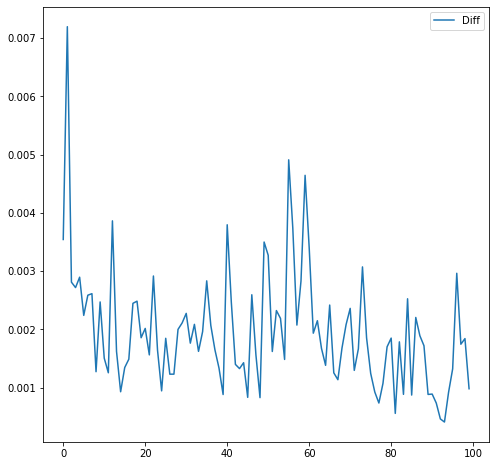

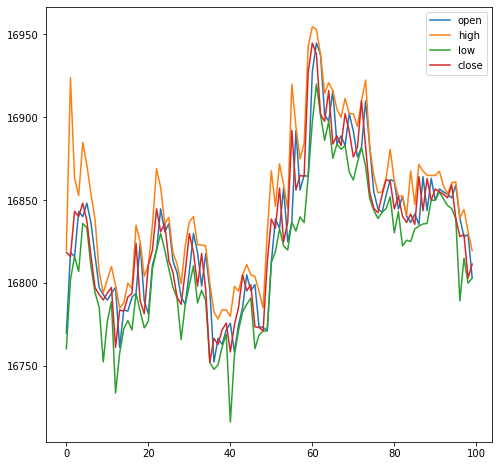

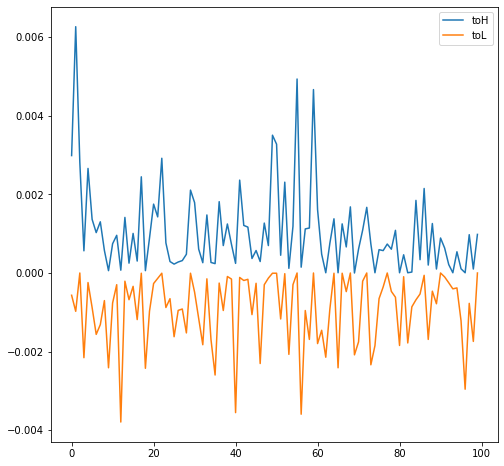

In [35]:
x = requests.get('https://binance.com/fapi/v1/klines?symbol='+symbol+'&limit='+str(100)+'&interval=5m')
dataset=pd.DataFrame(x.json())
dataset.to_json(r'export_dataframe.json')
dataset.columns=['open_time','open','high','low','close','volume','close_time','d1','d2','d3','d4','d5']
df=dataset.drop(['open_time','volume','close_time','d1','d2','d3','d4','d5'],axis=1)
df['open']=df['open'].astype(float)
df['high']=df['high'].astype(float)
df['low']=df['low'].astype(float)
df['close']=df['close'].astype(float)
openmean=df['open'].mean()
dfa=pd.DataFrame((df['high']-df['low'])/df['high'],columns= ['Diff'])
diff=dfa.mean()
dfaf=pd.DataFrame()
dfaf['toH']=pd.DataFrame((df['high']-df['open'])/df['open'])
dfaf['toL']=pd.DataFrame((df['low']-df['open'])/df['open'])

print(diff,openmean)
dfa.plot(figsize=(8,8))
df.plot(figsize=(8,8))
dfaf.plot(figsize=(8,8))


In [28]:
def get_direction(symbol):
    trades = client.futures_account_trades(symbol=symbol)[-1:]
    dataset = pd.DataFrame(trades)
    resdata = float(dataset['realizedPnl'])
    direction=1
    if resdata < 0:
        direction=0
    return(direction)

In [29]:
get_direction(symbol)

1

In [30]:
def changer(symbol):
    direction=get_direction(symbol)
    f = open("directdoc.txt", "r")
    direc=f.read()
    stop=stop_percent/ingebit
    profit=profit_percent/ingebit
    quant=str(round(float(quantity)/ingebit,roundity))
    if direction==1: #не меняем
        if direc=='0':
            open_position_long(symbol,quant,tick_size,profit,profit)
            f = open("directdoc.txt", "w")
            f.write("1")
            f.close()
            print('Direction switched from SHORT to LONG')
        else:
            open_position_short(symbol,quant,tick_size,profit,profit)
            print('Direction switched from LONG to SHORT')
            f = open("directdoc.txt", "w")
            f.write("0")
            f.close()
    else: #реверс
        if direc=='0':
            target=open_position_short(symbol,quantity,tick_size,profit,profit)
            print('Direction SHORT again')
            f = open("directdoc.txt", "w")
            f.write("0")
            f.close()
        if direc=='1':
            target=open_position_long(symbol,quantity,tick_size,profit,profit)
            print('Direction LONG again')
            f = open("directdoc.txt", "w")
            f.write("1")
            f.close()

In [31]:
def check_positions_new(symbol):
    positions=get_opened_positions(symbol)
    if positions==0:
        orders=client.futures_get_open_orders(symbol=symbol)
        orders_df=pd.DataFrame(orders)
        if orders_df.empty:
            changer(symbol)

In [32]:
def main(step):
    #getTPSLfrom_telegram()
    try:
        x = threading.Thread(target=check_positions_new(symbol))
        x.start()
        y = threading.Thread(target=get_profit(symbol))
        y.start()   
    except :
        print('\n\nSomething went wrong. Continuing...')

In [33]:
telegram_delay=12
bot_token='5454990445:AAGzfeY80oeI-1su0MEIRVuvTzBYIVlZIXU'
chat_id='92428939'

def getTPSLfrom_telegram():
    strr='https://api.telegram.org/bot'+bot_token+'/getUpdates'
    response = requests.get(strr)
    rs=response.json()
    exit=0

    if(len(rs['result'])>0):
        rs2=rs['result'][-1]
        rs3=rs2['message']
        textt=rs3['text']
        datet=rs3['date']        
        if(time.time()-datet)<telegram_delay:
            if 'exit' in textt:
                exit=1
                telegram_bot_sendtext('Right now! Sir')
            if 'profit' in textt:
                trades = client.futures_account_trades(symbol=symbol)
                dataset=pd.DataFrame(trades).iloc[-50:]
                bnbdata=dataset[dataset['commissionAsset']=='BNB']
                busddata=dataset[dataset['commissionAsset']==asset]
                bnbcom=bnbdata['commission'].astype(float).sum()
                busdcom=busddata['commission'].astype(float).sum()
                com=(bnbcom*270+busdcom)*-1
                real=dataset['realizedPnl'].astype(float).sum()
                profit=com+real
                telegram_bot_sendtext('Profit = ' + str(profit))

    return(exit)

In [34]:
def telegram_bot_sendtext(bot_message):
    bot_token2 = bot_token
    bot_chatID = chat_id
    send_text = 'https://api.telegram.org/bot' + bot_token2 + '/sendMessage?chat_id=' + bot_chatID + '&parse_mode=Markdown&text=' + bot_message
    response = requests.get(send_text)
    return response.json()

In [35]:
def prt(message):
    # telegram message
    telegram_bot_sendtext(pointer+': '+message)
    print(pointer+': '+message)

In [36]:
def start_stop():
    starttime=time.time()
    counterr=1
    timeout = time.time() + 60*60*6  # 60 seconds times 60 meaning the script will run for 12 hr
    while time.time() <= timeout:
        try:

            print("script continue running at "+time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
            main(counterr)
            counterr=counterr+1
            # stop=getTPSLfrom_telegram()
            # if stop==1:
            #     break
            if counterr>3:
                # break
                counterr=1
            time.sleep(4 - ((time.time() - starttime) % 4.0)) # 1 minute interval between each new execution
        except KeyboardInterrupt:
            print('\n\KeyboardInterrupt. Stopping.')
        

In [ ]:
start_stop()

script continue running at 2022-11-11 10:52:14
SHORT order opened price:1269.22
Direction switched from LONG to SHORT
0.009152400000000002
SHORT sl order opened price:1272.96
SHORT tp order opened price:1268.9
script continue running at 2022-11-11 10:52:18
0.009152400000000002
script continue running at 2022-11-11 10:52:22
0.009152400000000002
script continue running at 2022-11-11 10:52:26
0.009152400000000002
script continue running at 2022-11-11 10:52:30
0.009152400000000002
script continue running at 2022-11-11 10:52:34
0.009152400000000002
script continue running at 2022-11-11 10:52:38
0.009152400000000002
script continue running at 2022-11-11 10:52:42
0.009152400000000002
script continue running at 2022-11-11 10:52:46
0.009152400000000002
script continue running at 2022-11-11 10:52:50
0.009152400000000002
script continue running at 2022-11-11 10:52:54
0.009152400000000002
script continue running at 2022-11-11 10:52:58
0.009152400000000002
script continue running at 2022-11-11 10:5